# 1-D Convection with Devito

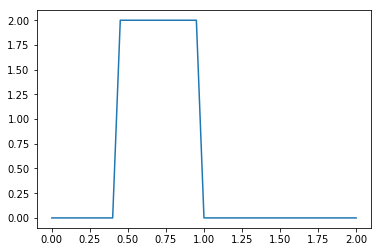

In [2]:
nx = 41
nt = 25 
dt = 0.025
c = 1

from devito import Grid
grid = Grid(shape=(41), extent=(2.))

from devito import TimeFunction
u = TimeFunction(name='u', grid=grid)
for i in range(9,20):
   u.data[0][i] = 2.

import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.linspace(0, 2, nx), u.data[0])
plt.show()

In [3]:
from devito import Eq
eq = Eq(u.dt + c*u.dxl)

from sympy import pprint
pprint(eq)

u(t, x)   u(t, x - hₓ)   u(t, x)   u(t + dt, x)    
─────── - ──────────── - ─────── + ──────────── = 0
   hₓ          hₓ           dt          dt         


In [4]:
u.dt

-u(t, x)/dt + u(t + dt, x)/dt

In [5]:
u.dxl

u(t, x)/h_x - u(t, x - h_x)/h_x

In [6]:
u.dxr

-u(t, x)/h_x + u(t, x + h_x)/h_x

In [7]:
u.dx

-u(t, x)/h_x + u(t, x + h_x)/h_x

In [8]:
u.forward

u(t + dt, x)

In [9]:
u.backward

u(t - dt, x)

In [10]:
from sympy import init_printing; init_printing(use_latex='mathjax')
eq

u(t, x)   u(t, x - hₓ)   u(t, x)   u(t + dt, x)    
─────── - ──────────── - ─────── + ──────────── = 0
   hₓ          hₓ           dt          dt         

In [11]:
from sympy import solve
stencil = solve(eq, u.forward)
stencil

⎡-dt⋅u(t, x) + dt⋅u(t, x - hₓ) + hₓ⋅u(t, x)⎤
⎢──────────────────────────────────────────⎥
⎣                    hₓ                    ⎦

In [12]:
stencil[0]

-dt⋅u(t, x) + dt⋅u(t, x - hₓ) + hₓ⋅u(t, x)
──────────────────────────────────────────
                    hₓ                    

In [13]:
update = Eq(u.forward, stencil[0])
update

               -dt⋅u(t, x) + dt⋅u(t, x - hₓ) + hₓ⋅u(t, x)
u(t + dt, x) = ──────────────────────────────────────────
                                   hₓ                    

In [14]:
from devito import Operator
op = Operator(update)
print(op)

#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct profiler
{
  double section0;
} ;


int Kernel(const float dt, const float h_x, float *restrict u_vec, const int time_M, const int time_m, struct profiler* timers, const int x_M, const int x_m, const int x_size)
{
  float (*restrict u)[x_size + 1 + 1] __attribute__((aligned(64))) = (float (*)[x_size + 1 + 1]) u_vec;
  /* Flush denormal numbers to zero in hardware */
  _MM_SET_DENORMALS_ZERO_MODE(_MM_DENORMALS_ZERO_ON);
  _MM_SET_FLUSH_ZERO_MODE(_MM_FLUSH_ZERO_ON);
  for (int time = time_m, t0 = (time)%(2), t1 = (time + 1)%(2); time <= time_M; time += 1, t0 = (time)%(2), t1 = (time + 1)%(2))
  {
    struct timeval start_section0, end_section0;
    gettimeofday(&start_section0, NULL);
    for (int x = x_m; x <= x_M; x += 1)
    {
      u[t1][x + 1] = (dt*u[t0][x] - dt*u[t0][x + 1] + h_x*u[t0][x + 1])/h_x;
    }
    gettimeofday(&end_section0, N

Now we can execute the created operator for a number of timesteps. We specify the number of timesteps to compute with the keyword `time` and the timestep size with `dt`.

In [15]:
op(time=nt+1, dt=dt)

Operator `Kernel` run in 0.00 s


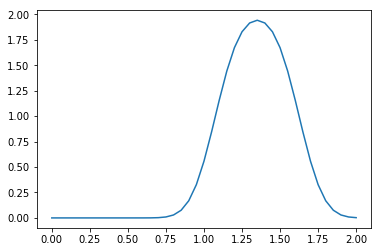

In [16]:
plt.plot(np.linspace(0, 2, nx), u.data[0])
plt.show()